In [1]:
import ngmix
import fitsio
import proplot as pplt
import numpy as np
import piff
import galsim
import yaml

In [2]:
%matplotlib inline

In [4]:
TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]

with open(
    "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
    "%s_%s_pizza_cutter_info.yaml" % (TNAMES[0], BANDS[0])
) as fp:
    yml = yaml.safe_load(fp.read())

In [568]:
import scipy.optimize

def _get_star_stamp_pos(s, img, wgt, bbox):
    xint = int(np.floor(s.x - 1 + 0.5))
    yint = int(np.floor(s.y - 1 + 0.5))
    bbox_2 = (bbox - 1)//2

    return dict(
        img=img[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1].copy(),
        wgt=wgt[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1].copy(),
        xstart=xint-bbox_2,
        ystart=yint-bbox_2,
        dim=bbox,
        x=s.x - 1,
        y=s.y - 1,
    )


def get_star_obs(piff_mod, s, img, wgt, piff_prop, star_dim):

    if piff_prop:
        kwargs = {
            piff_prop: s.data.properties[piff_prop]
        }
    else:
        kwargs = {}
    sres = _get_star_stamp_pos(s, img, wgt, star_dim)
    sres.update(**kwargs)

    xv = sres["x"]+1
    yv = sres["y"]+1
    wcs = list(piff_mod.wcs.values())[0].local(
        image_pos=galsim.PositionD(x=xv, y=yv)
    ).jacobian()
    img = galsim.ImageD(sres["dim"], sres["dim"], wcs=wcs)
    cen = (
        sres["x"] - sres["xstart"] + 1,
        sres["y"] - sres["ystart"] + 1,
    )
    _img = sres.pop("img")
    _wgt = sres.pop("wgt")
    nrm = _img.sum()
    nrm2 = nrm*nrm
    _img /= nrm
    _wgt *= nrm2
    
    star_obs = ngmix.Observation(
        image=_img,
        weight=_wgt,
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    sres["local_wcs"] = wcs
    star_obs.update_meta_data(sres)
    
    if star_obs.get_s2n() > 100:
        nse = np.sqrt(np.sum(star_obs.image**2)) / 100
        star_obs.weight = np.ones_like(star_obs.weight) / nse**2

    return star_obs


def _make_galsim_model(*, img, dilation, g1, g2, scale, dim):
    img = img.reshape((dim, dim))
    return galsim.InterpolatedImage(
        galsim.ImageD(img), scale=scale, x_interpolant="lanczos3",
    ).dilate(
        dilation
    ).shear(
        eta1=g1, eta2=g2
    )
    

def _draw_galsim_model(*, mod, offset_x, offset_y, local_wcs, dim):
    return mod.drawImage(
        nx=dim, ny=dim, 
        wcs=local_wcs, 
        offset=galsim.PositionD(x=offset_x, y=offset_y),
        method="no_pixel",
    ).array


def _predict_star(
    *, xy_params, dilation_params, g1_params, g2_params, 
    star_xy, star_colxy, offset_x, offset_y, local_wcs,
    star_dim, model_dim, model_scale, piff_model,
):
    _pp = xy_params.reshape((model_dim*model_dim, 4))
    img = np.dot(_pp, star_xy)
    dilation = 1.0 + np.dot(dilation_params, star_colxy)
    g1 = np.dot(g1_params, star_colxy)
    g2 = np.dot(g2_params, star_colxy)
    mod = _make_galsim_model(
        img=img, 
        dilation=dilation, 
        g1=g1, 
        g2=g2,
        scale=model_scale,
        dim=model_dim,
    )
    img = _draw_galsim_model(
        mod=mod, 
        offset_x=offset_x,
        offset_y=offset_y, 
        local_wcs=local_wcs, 
        dim=star_dim,
    )
        
    return img


def _build_star_xy_colxy(*, x, y, col, colcen, colscale, xcen=1024, ycen=2048, xyscale=2048):
    xs = (x-xcen)/xyscale
    ys = (y-ycen)/xyscale
    cols = (col-colcen)/colscale
    
    return np.array([1, xs, xs, xs*ys]), np.array([cols, xs*cols, ys*cols, cols*cols])


def _init_model_params(*, model_dim, rng, stars, model_scale, init_scale, poly_guess):
    # grid + dilation + 2 shears + n_stars * 3 (offset_x, offset_y, flux)
    n_stars = len(stars)
    tot = model_dim*model_dim*4 + 4 + 2*4 + n_stars*2
    nse = rng.normal(size=tot, scale=init_scale)
    nn = model_dim**2
    nse[0:nn*4] += poly_guess
    return nse


def _extract_model_params(params, fit_data):
    nxy = fit_data["model_dim"]**2 * 4
    xy_params = params[0:nxy]
    dilation_params = params[nxy:nxy+4]
    g1_params = params[nxy+4:nxy+8]
    g2_params = params[nxy+8:nxy+12]
    
    return nxy, xy_params, dilation_params, g1_params, g2_params
    

def _compute_model_resid(params, fit_data):
    nxy, xy_params, dilation_params, g1_params, g2_params = _extract_model_params(
        params, fit_data
    )
    star_params = params[nxy+12:]
    
    n_resids_per_star = fit_data["star_dim"]**2 + 2
    n_resids = fit_data["n_stars"] * n_resids_per_star
    resids = np.zeros(n_resids)
    rloc = 0
    for sind, sobs in enumerate(fit_data["stars"]):
        xy, colxy = _build_star_xy_colxy(
            x=sobs.meta["x"] + star_params[2*sind+0], 
            y=sobs.meta["y"] + star_params[2*sind+1], 
            col=sobs.meta["col"], 
            colcen=fit_data["colcen"], 
            colscale=fit_data["colscale"],
        )
        
        simg = _predict_star(
            xy_params=xy_params, 
            dilation_params=dilation_params, 
            g1_params=g1_params, 
            g2_params=g2_params, 
            star_xy=xy, 
            star_colxy=colxy, 
            offset_x=star_params[2*sind+0] + sobs.meta["cen_offset_x"], 
            offset_y=star_params[2*sind+1] + sobs.meta["cen_offset_y"], 
            local_wcs=sobs.meta["local_wcs"],
            star_dim=fit_data["star_dim"], 
            model_dim=fit_data["model_dim"], 
            model_scale=fit_data["model_scale"],
        )
        simg = simg.ravel()
        resids[rloc:rloc+simg.shape[0]] = (sobs.image.ravel() - simg) * sobs.meta["sqrt_wgt_ravel"]
        resids[rloc+simg.shape[0]+0] = star_params[2*sind+0]/fit_data["offset_width"]
        resids[rloc+simg.shape[0]+1] = star_params[2*sind+1]/fit_data["offset_width"]
        rloc += n_resids_per_star
        
    if fit_data["itr"] % 100 == 0:
        n_data = len(fit_data["stars"]) * fit_data["star_dim"]**2
        print("itr:", fit_data["itr"])
        print("    chi2/dof:", np.sum(resids**2)/(n_data - len(params)))
        print("    params:", params.min(), params.max())
        print("    resids:", resids.min(), resids.max())
        if "last_params" in fit_data:
            print("    diff params:", np.max(np.abs(fit_data["last_params"] - params)))
    fit_data["itr"] = fit_data["itr"] + 1
    fit_data["last_params"] = params.copy()
    
        
    return resids
    

def _build_fit_data(
    *, star_dim, model_dim, model_scale, offset_width, 
    stars, colname, colcen, colscale, init_scale,
):
    fit_data = dict(
        star_dim=star_dim,
        model_dim=model_dim,
        offset_width=offset_width,
        stars=stars,
        colcen=colcen,
        colscale=colscale,
        model_scale=model_scale,
        n_stars=len(stars),
        colname=colname,
        init_scale=init_scale,
    )
    for star in stars:
        star.meta["sqrt_wgt_ravel"] = np.sqrt(np.ravel(star.weight))
        star.meta["cen_offset_x"] = star.meta["x"] - np.floor(star.meta["x"] + 0.5)
        star.meta["cen_offset_y"] = star.meta["y"] - np.floor(star.meta["y"] + 0.5)
        star.meta["col"] = star.meta[colname]
    fit_data["stars"] = stars
    
    images = np.array([
        galsim.InterpolatedImage(
            galsim.ImageD(s.image), 
            wcs=s.meta["local_wcs"], 
            offset=(s.meta["cen_offset_x"], s.meta["cen_offset_y"]),
            flux=1,
        ).drawImage(nx=model_dim, ny=model_dim, scale=model_scale, method="no_pixel").array.ravel()
        for s in stars
    ])
    
    coeffs = np.array([
        _build_star_xy_colxy(
            x=s.meta["x"], y=s.meta["y"], col=s.meta["col"], 
            colcen=colcen, colscale=colscale,
        )[0]
        for s in stars
    ])
    A = np.linalg.lstsq(coeffs, images, rcond=None)[0]
    fit_data["poly_guess"] = A.T.ravel()
    
    return fit_data


class MattsColorModel(object):
    """TODO
    """
    def __init__(
        self, 
        *,
        piff_model, image, weight, 
        colname, colcen, colscale,
        init_scale=0.01,
        star_dim=17, model_dim=17, offset_width=0.5, 
        model_scale=0.3,
        seed=None,
    ):
        self.image = image
        self.weight = weight
        self.piff = piff_model
        stars = [
            get_star_obs(self.piff, s, self.image, self.weight, colname, star_dim)
            for s in self.piff.stars
        ]

        self.fit_data = _build_fit_data(
            star_dim=star_dim, 
            model_dim=model_dim, 
            offset_width=offset_width,
            stars=stars, 
            colname=colname, 
            colcen=colcen, 
            colscale=colscale,
            model_scale=model_scale,
            init_scale=init_scale,
        )
        self.stars = self.fit_data["stars"]

        self.rng = np.random.RandomState(seed=seed)
        self.wcs = {0: None}
        
    def fit(self, **kwargs):
        x0 = self.get_init_params()
        self.fit_data["itr"] = 0
        self.fit_res = scipy.optimize.least_squares(
            _compute_model_resid, 
            x0, 
            args=(self.fit_data,), 
            **kwargs,
        )
    
    def get_init_params(self, init_scale=None):
        return _init_model_params(
                model_dim=self.fit_data["model_dim"], 
                rng=self.rng, 
                stars=self.fit_data["stars"], 
                model_scale=self.fit_data["model_scale"],
                init_scale=init_scale or self.fit_data["init_scale"],
                poly_guess=self.fit_data["poly_guess"],
            )
    
    def draw(self, x, y, offset=None, params=None, **kwargs):
        if self.fit_data["colname"] in kwargs:
            col = kwargs[self.fit_data["colname"]]
        else:
            col = self.fit_data["colcen"]
        
        if params is not None or not hasattr(self, "fit_res"):
            params = self.get_init_params()
        else:
            params = self.fit_res.x
        
        x -= 1
        y -= 1
        wcs = list(self.piff.wcs.values())[0].local(
            image_pos=galsim.PositionD(x=x+1, y=y+1)
        ).jacobian()

        xy, colxy = _build_star_xy_colxy(
            x=x, y=y, col=col, colcen=self.fit_data["colcen"], colscale=self.fit_data["colscale"]
        )
        
        _, xy_params, dilation_params, g1_params, g2_params = _extract_model_params(
            params, self.fit_data
        )
        
        if offset is None:
            offset = (
                x - np.floor(x+0.5),
                y - np.floor(y+0.5),
            )
        
        return galsim.ImageD(
            _predict_star(
                xy_params=xy_params, 
                dilation_params=dilation_params, 
                g1_params=g1_params, 
                g2_params=g2_params, 
                star_xy=xy, 
                star_colxy=colxy, 
                offset_x=offset[0], 
                offset_y=offset[1], 
                local_wcs=wcs,
                star_dim=self.fit_data["star_dim"], 
                model_dim=self.fit_data["model_dim"], 
                model_scale=self.fit_data["model_scale"],
            ),
            wcs=wcs,
        )

In [569]:
sind = 15

src = yml["src_info"][sind]
piff_mod = piff.read(src["piff_path"])

img = (
    fitsio.read(src["image_path"], ext=src["image_ext"])
    - fitsio.read(src["bkg_path"], ext=src["bkg_ext"])
)
wgt = fitsio.read(src["weight_path"], ext=src["weight_ext"])

In [570]:
mmod = MattsColorModel(
    piff_model=piff_mod, 
    image=img, 
    weight=wgt, 
    colname="GI_COLOR", 
    colcen=1.6, 
    colscale=1.5,
    init_scale=0,
)

In [545]:
from des_y6utils.piff import measure_t_grid_for_piff_model


res_me = measure_t_grid_for_piff_model(mmod, {"GI_COLOR": 1.61})
res_piff = measure_t_grid_for_piff_model(piff_mod, {"GI_COLOR": 1.61})

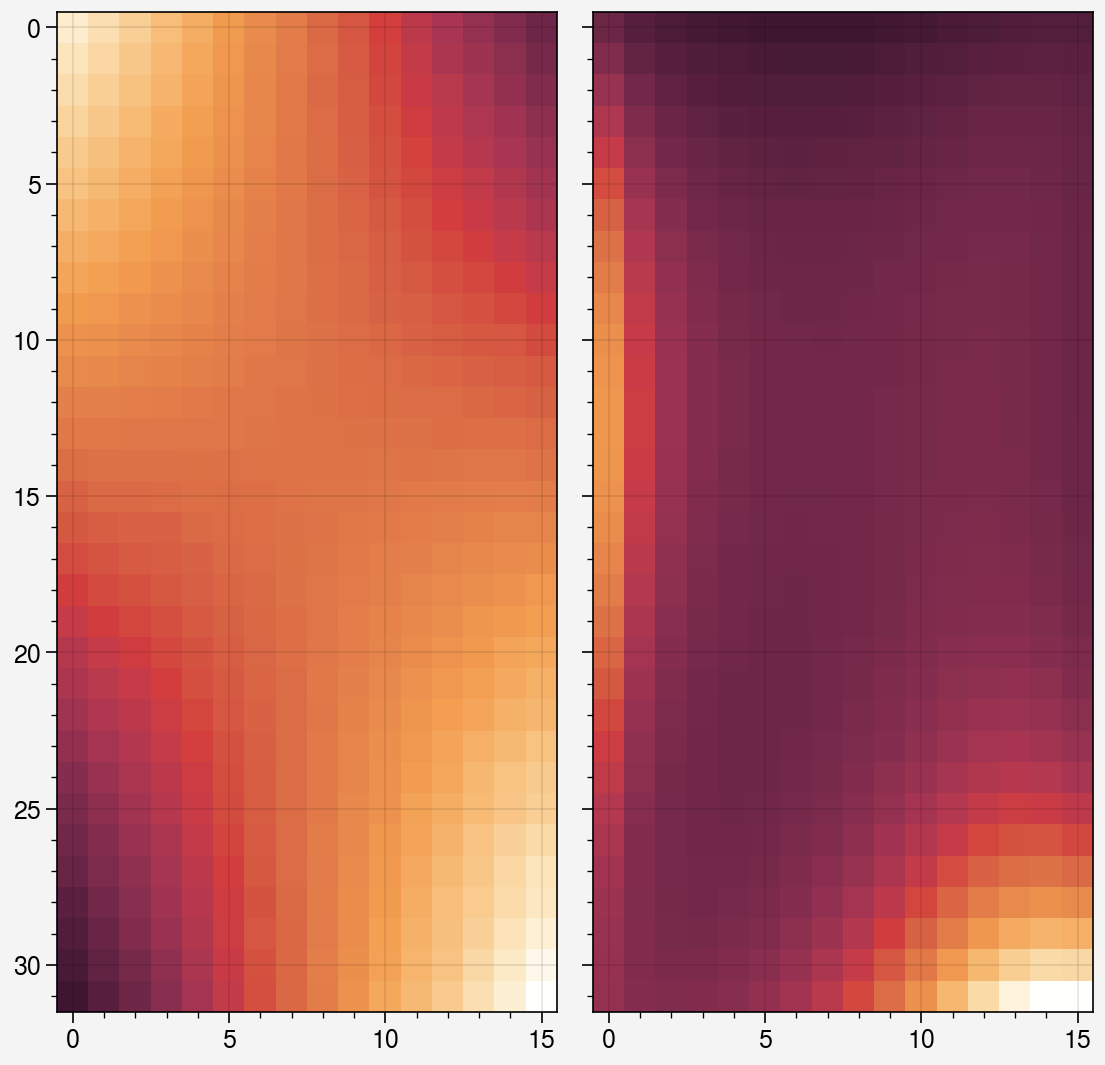

In [546]:
fig, axs = pplt.subplots(ncols=2)
axs[0].imshow(res_me)
axs[1].imshow(res_piff)

In [547]:
p = mmod.get_init_params()

In [548]:
p[:17*17*4].reshape(17*17,4)[8*17+8, :]

array([0.08336967, 0.00075322, 0.00075322, 0.00314111])

In [549]:
assert not np.array_equal(mmod.draw(x=10, y=100, GI_COLOR=0.61), mmod.draw(x=10, y=100, GI_COLOR=0.61))

AssertionError: 

0.9989980325790417 0.997885695235027 1.0000000608001756


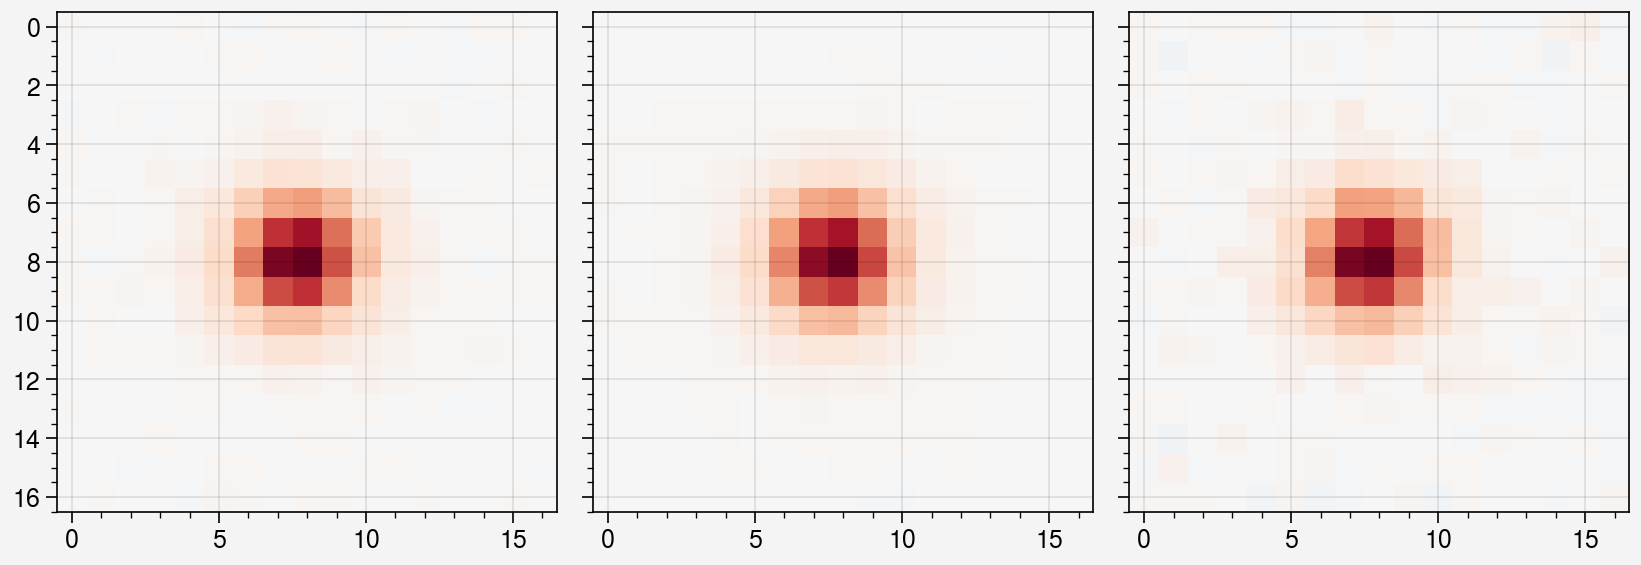

In [571]:
i = 24
_img = mmod.draw(x=mmod.stars[i].meta["x"], y=mmod.stars[i].meta["y"], GI_COLOR=mmod.stars[i].meta["col"])

piff_img = piff_mod.draw(
    x=mmod.stars[i].meta["x"], 
    y=mmod.stars[i].meta["y"], 
    GI_COLOR=mmod.stars[i].meta["col"], 
    chipnum=list(piff_mod.wcs.keys())[0],
)
print(np.sum(piff_img.array), np.sum(_img.array), np.sum(mmod.stars[i].image))
fig, axs = pplt.subplots(nrows=1, ncols=3)
xcen = piff_img.center.x - piff_img.bounds.xmin
ycen = piff_img.center.y - piff_img.bounds.ymin
axs[0].imshow(piff_img.array[ycen-8:ycen+8+1, xcen-8:xcen+8+1])
axs[1].imshow(_img.array)
axs[2].imshow(mmod.stars[i].image)

In [575]:
mmod.fit(method="trf", verbose=2, diff_step=1e-4)

itr: 0
    chi2/dof: 0.7083242464208221
    params: -0.004694873147803617 0.08336966942756588
    resids: -6.609802377778017 5.565011995716063
    diff params: 0.09089893854011719
itr: 100
    chi2/dof: 0.7083384430061159
    params: -0.004694873147803617 0.08336966942756588
    resids: -6.609802377778017 5.565011995716063
    diff params: 0.00010000000000000005
itr: 200
    chi2/dof: 0.7083393352590888
    params: -0.004694873147803617 0.08336966942756588
    resids: -6.609802377778017 5.565011995716063
    diff params: 0.00010000000000000005
itr: 300
    chi2/dof: 0.7083366178087386
    params: -0.004694873147803617 0.08336966942756588
    resids: -6.609802377778017 5.565011995716063
    diff params: 0.00010000000000000002
itr: 400
    chi2/dof: 0.7083253938632844
    params: -0.004694873147803617 0.08336966942756588
    resids: -6.609802377778017 5.565011995716063
    diff params: 0.00010000000000000005
itr: 500
    chi2/dof: 0.7083313883990857
    params: -0.004694873147803617 0.08

KeyboardInterrupt: 

In [573]:
piff_mod.chisq / piff_mod.dof

0.3533296251660292

In [38]:
%debug

> <__array_function__ internals>(5)dot()

ipdb> up
> /var/folders/5w/65hhf7d16cvbrv_wsj7y1_nm0000gn/T/ipykernel_48195/2272773573.py(80)_predict_star()
     78 ):
     79     img = np.dot(xy_params.reshape((model_dim*model_dim, 4)), star_xy)
---> 80     dilation = 1.0 + np.dot(dilation_params, star_colxy)
     81     g1 = np.dot(g1_params, star_colxy)
     82     g2 = np.dot(g2_params, star_colxy)

ipdb> p dilation_params
array([ 0.12174927, -0.06653615, -0.02447815, -0.04616981])
ipdb> p star_colxy
array([0.63554663])
ipdb> exit


In [576]:
piff_mod.get_profile?

In [ ]:
thresh = 10
t_arr = measure_t_grid_for_piff_model(piff_mod, {"GI_COLOR": 0.61})
data = measure_star_t_for_piff_model(piff_mod, img, wgt, piff_prop="GI_COLOR")
ts_arr = map_star_t_to_grid(data)

res_g = make_good_regions_for_piff_model_gal_grid(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=11, verbose=False)
res_sg = make_good_regions_for_piff_model_star_and_gal_grid(
    piff_mod, img, wgt, piff_kwargs={"GI_COLOR": 0.61}, seed=11, verbose=False,
    flag_bad_thresh=thresh, any_bad_thresh=thresh,
)

In [ ]:
vmin = min(np.nanmin(ts_arr), np.nanmin(t_arr))
vmax = max(np.nanmax(ts_arr), np.nanmax(t_arr))

fig, axs = pplt.subplots(ncols=3, share=0)
h0 = axs[0].imshow(ts_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[0].grid(False)
axs[0].set_title("stars on grid w/ 2d poly")
axs[0].colorbar(h0, loc='l')

axs[1].imshow(t_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[1].grid(False)
axs[1].set_title("grid of shapes at gal color")

b = res_g["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="red")

b = res_sg["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="blue")

harr = (t_arr-ts_arr).ravel()
std5 = nanmad(harr) * thresh
h = axs[2].hist(harr, bins=50)
axs[2].vlines([-std5, np.nanmedian(harr)+std5], 0, np.max(h[0]), color="k")
axs[2].set_xlabel("gal T - star T")
ax = axs[0]

In [ ]:
import ngmix

def get_star_stamp_pos(s, img, wgt):
    xint = int(np.floor(s.x - 1 + 0.5))
    yint = int(np.floor(s.y - 1 + 0.5))
    bbox = 17
    bbox_2 = (bbox - 1)//2
    
    return dict(
        img=img[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        wgt=wgt[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        xstart=xint-bbox_2, 
        ystart=yint-bbox_2,
        dim=bbox,
        x=s.x - 1,
        y=s.y - 1,
    )

def get_star_piff_obs(piff_mod, s, img, wgt):
    
    sres = get_star_stamp_pos(s, img, wgt)
    
    xv = sres["x"]+1
    yv = sres["y"]+1
    wcs = list(piff_mod.wcs.values())[0].local(
        image_pos=galsim.PositionD(x=xv, y=yv)
    ).jacobian()
    img = galsim.ImageD(sres["dim"], sres["dim"], wcs=wcs)
    cen = (
        sres["x"] - sres["xstart"] + 1,
        sres["y"] - sres["ystart"] + 1,
    )
    img = piff_mod.draw(
        x=xv, y=yv, chipnum=list(piff_mod.wcs.keys())[0],
        GI_COLOR=s.data.properties["GI_COLOR"],
        image=img, center=cen,
    )
    model_obs = ngmix.Observation(
        image=img.array,
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    star_obs = ngmix.Observation(
        image=sres["img"],
        weight=sres["wgt"],
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    return model_obs, star_obs, sres

In [ ]:

x = []
y = []
t = []

for s in piff_mod.stars:

    mobs, sobs, sres = get_star_piff_obs(piff_mod, s, img, wgt)
    
    res = ngmix.admom.AdmomFitter(
        rng=np.random.RandomState(seed=10)
    ).go(mobs, ngmix.moments.fwhm_to_T(1))
    t.append(res["T"])
    x.append(sres["x"])
    y.append(sres["y"])
    

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(np.array([x, y]).T, np.array(t))

In [ ]:
y, x = np.mgrid[0:4096:128, 0:2048:128] + 64
tg = polyreg.predict(np.array([x.ravel(), y.ravel()]).T)

In [ ]:
tg = tg.reshape(x.shape)

In [ ]:
fig, axs = pplt.subplots(ncols=2)
axs[0].imshow(tg)
axs[1].imshow(res["t_arr"])

In [ ]:
def _nanmad(x, axis=None):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis : {int, sequence of int, None}, optional
        `axis` keyword for

    Returns
    -------
    mad: float
        MAD of array x
    """
    return 1.4826*np.nanmedian(np.abs(x - np.nanmedian(x, axis=axis)), axis=axis)


In [ ]:
print(_nanmad(t), _nanmad(tg))

In [ ]:
from des_y6utils.piff import make_good_regions_for_piff_model

In [ ]:
res = make_good_regions_for_piff_model(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=10, verbose=False)

In [ ]:
res["t_std"]

In [ ]:
fig, axs = pplt.subplots()

axs.hist((res["t_arr"] - tg).ravel(), bins=50)

In [ ]:
np.std((res["t_arr"] - tg).ravel()) * 5

In [ ]:
np.max(np.abs(np.max(t) - np.median(t)))

In [ ]:
_nanmad(t)

In [359]:
img = np.ones((17, 17))* 5
print(img.sum())
gs = galsim.InterpolatedImage(galsim.ImageD(img), scale=0.3, x_interpolant="lanczos3", normalization="flux")

print(gs.drawImage(nx=27, ny=27, scale=0.263, method="no_pixel").array.sum())

1445.0
1442.9114
